<h1 style="text-align:center;"><font color='red' size=10><b> Before you start! </b></font></h1>

This project is divided in 3 parts:

**1) ETL, where we will Extract, Transform and Load data into an AWS RDS.  <font color='red'>-> you are here</font>**

https://colab.research.google.com/drive/1w9bPc49joLrceMWAF_RlEgXo73s1Eeee?usp=sharing

<br><br>

2) Data Analysis: exploratory data analysis to identify key features

https://colab.research.google.com/drive/1a_Etj5kwEaq5epwoV9TVPNS3ShRRd7wU?usp=sharing

<br><br>

3) Prediction models: model building and comparison.

https://colab.research.google.com/drive/1Nbj6TM5HaK2krMRa9R1oiolDhDronYQB?usp=sharing

<br><br>

Summary of this project: https://colab.research.google.com/drive/1CUjP7SdFGldPjuSVSIbHAk9UPWYp_RYz?usp=sharing

<br><br>


A summary of the data can be visualized on this <font color='red'>**Power BI dashboard:**</font> https://app.powerbi.com/view?r=eyJrIjoiNTkzZjNmY2UtNmQ5Mi00MTJhLTliNzgtZGU2NzRlYzQ5NDA1IiwidCI6IjE2OGQ0MTM3LWQ2ZjYtNDVmOC1hYWE3LWQxYTcwMjMzMDk1ZSIsImMiOjR9&pageName=ReportSection4f69a4c8629ea033a165

# **Analyzing Youtube channels that I am subscribed to using its API.**

I love watching Youtube. It's a very diverse streaming service (even before video streaming was a thing), with videos ranging from comedy to science and curiosity, short or long, from channels with millions of subscribers to small comunnities with just a few hundred. 

But content creators suffer from "punitive algorithms" (in their words) that increase or decrease their visibility based on a plethora of metrics, more often than ever unknown to them. From YT perspective it's actually understandable, since a lot of viewers are migrating to other platforms (Tiktok, Twitch and an ever growing streaming services options). They need to maximize the amount of viewers and time spent on each video to justify that Youtube is actually a good platform to place ads.

With this in mind I decided to use its API to collect some data and try to predict a video "view count" at the time it was published. Some models were built using video title features, thumbnail color, day and hour it was published, and so on. If successful, it could be used for example to fine tune ad placement in terms of expected return it will give. If unsuccessful it can at least be improved in future iterations.





# **0) Import libraries**

In [2]:
#!pip install psycopg2
!pip install python-dotenv

# Import libraries
import requests
import pandas as pd
import time
import datetime
import pytz
import numpy as np
import psycopg2 as ps
from google.colab import drive
import os

# Regular expressions
import re

# Environment variables
from dotenv import load_dotenv

# Image processing
import matplotlib.image as img
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from io import BytesIO
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **1) EXTRACT**

## 1.1) Import API keys
The API key is in an environment variable that needs to be loaded from a .env file. Since Google Colab won't persist files between sessions, you need to store the .env file on your Googl Drive and then import/copy that file from yout private Google Drive to this Colab Notebook.

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/My\ Drive/Profissional/Data\ Science/Projects/Youtube\ DS/.env .env # this should be *YOUR* path inside Google Drive to the '.env' file
drive.flush_and_unmount()
load_dotenv()

True

In [5]:
# Keys
API_KEY = os.getenv("API_KEY")

## 1.2) Methods to extract data from video uploads

In [6]:
def check_response_successful(response):
    """ Checks if the response from a given request was succesful.
    
    Raise an exception if an error was found, or
    returns True otherwise.
    """
    try:
        error = response['error']
        error_code = error['code']
        error_message = error['message']
        raise Exception(f"{error_code}. \"{error_message}\"")
    except KeyError:
        return True
        

In [7]:
def get_video_details(video_id):
    """ Get the video details from a video_id
    
    Returns the channel id, video title, thumbnail url, 
    upload timestamp(ISO 8601 standard), video duration (ISO 8601 standard), 
    view count, like count and comment count.

    Utilize 1 quota.
    """
    url = base_url+f"/videos?id={video_id}&part=snippet,contentDetails,statistics&key={API_KEY}"
    video_details = requests.get(url).json()
    response_sucessful = check_response_successful(video_details)

    channel_id = video_details['items'][0]['snippet']['channelId']
    video_title = video_details['items'][0]['snippet']['title']
    thumbnail_url = video_details['items'][0]['snippet']['thumbnails']['high']['url']
    upload_date_time = video_details['items'][0]['snippet']['publishedAt']

    video_duration = video_details['items'][0]['contentDetails']['duration']

    view_count = video_details['items'][0]['statistics']['viewCount']
    like_count = video_details['items'][0]['statistics']['likeCount']
    #dislike_count = like_count = video_details['items'][0]['statistics']['dislikeCount'] # from Dec 13th 2021, Youtube doesn't return dislike counts anymore
    comment_count = video_details['items'][0]['statistics']['commentCount']


    return channel_id, video_title, thumbnail_url, upload_date_time, video_duration, view_count, like_count, comment_count

In [8]:
def get_page_results(pageToken, channel_id, publishedAfter, publishedBefore):
    """ Get search results from a given page that match the channel_id,
    
    Returns the response.

    Utilize 100 quota.
    """
    
    url = base_url+f"/search?key={API_KEY}&channelId={channel_id}&part=id&publishedAfter={publishedAfter}&publishedBefore={publishedBefore}&order=date&maxResults=10000&pageToken={pageToken}"
    response = requests.get(url).json()

    return response

In [9]:
def get_videos_from_channel(df, channel_id, publishedAfter, publishedBefore):
    """ Get all videos from a channel (iterate all page results), 
    published after some date and before some date, and store them into a pandas
    df.

    Returns a pandas df with video id, channel id, video title, thumbnail url,
    upload date and time (ISO 8601 standard), video duration (ISO 8601 standard),
    view count, like count and comment count.

    Utilize 100 quota per page result and 1 quota per video of that page.
    """

    pageToken = ""
    # Iterate through all page results
    while pageToken is not None:
        # API call
        response = get_page_results(pageToken, channel_id, publishedAfter, publishedBefore)
        time.sleep(1)
        response_successful = check_response_successful(response)
                     
        pageToken = response.get('nextPageToken', None)

        # Iterate within page to get data
        for video in response['items']:
            if video['id']['kind'] == "youtube#video":
                # Get video description
                video_id = video['id']['videoId']

                channel_id, video_title, thumbnail_url, upload_date_time, \
                    video_duration, view_count, like_count, comment_count = get_video_details(video_id)

                # Save into pandas data frame
                df = df.append(
                    {"video_id": video_id,
                    "channel_id": channel_id,
                    "video_title": video_title,
                    "thumbnail_url": thumbnail_url,
                    "upload_date_time": upload_date_time,
                    "video_duration": video_duration,
                    "view_count": view_count,
                    "like_count": like_count,
                    "comment_count": comment_count},
                    ignore_index=True
                )

    return df

In [10]:
def get_videos_from_channel_list(df, channel_list, publishedAfter="", publishedBefore=""):
    """ Get all videos from a channel list, published after some date and before
    some date, and store it into a pandas df.

    Features extracted from each video depend on get_videos_from_channel.

    Returns a pandas df.

    Utilize 100 quota per page result per channel and 1 quota per video.
    """

    if publishedBefore=="":
        d = datetime.datetime.now()
        publishedBefore = d.strftime('%Y-%m-%dT%H:%M:%SZ')

    df_tmp = df

    for channel_id in channel_list:
        try:
            print(f"Getting videos from channel {channel_id}.\n")
            df_tmp = get_videos_from_channel(df, channel_id, publishedAfter, publishedBefore)
            df = df_tmp # doesn't throw away previous results in the case of a bad request
        except KeyError as e:
            print(f"Error: key not identified on response: {e}.")
        except Exception as e:
            print(f"Error: {e}.")
        
    # Sometimes the Youtube API returns duplicate data, so we need to remove it -> https://stackoverflow.com/questions/72438701/youtube-data-api-search-returning-repeating-items
    df = df.drop_duplicates(subset=['video_id'])
    
    return df

## 1.3) Methods to extract data from channels

In [11]:
def get_channel_details(df, channel_id):
    """ Get channel details from a channel id.

    Returns the channel title, country, total view count, subscriber count, 
    total number of videos and topic categories (a list of Wikipedia pages).
    
    Utilize 1 quota.
    """
    
    url = base_url+f"/channels?key={API_KEY}&id={channel_id}&part=snippet,statistics,topicDetails"
    response = requests.get(url).json()
    
    channel_title = response['items'][0]['snippet']['title']
    channel_country = response['items'][0]['snippet']['country']
    total_view_count = response['items'][0]['statistics']['viewCount']
    subscriber_count = response['items'][0]['statistics']['subscriberCount']
    video_count = response['items'][0]['statistics']['videoCount']
    topic_categories = response['items'][0]['topicDetails']['topicCategories']

    return channel_title, channel_country, total_view_count, subscriber_count, video_count, topic_categories

In [12]:
def get_channels_from_channel_list(df, channel_list):
    """ Get all channels from a channel list store it into a pandas df.

    Returns a pandas df with channel id, channel title, channel country,
    total view count, subscriber count, video count and topic categories
    (a list of Wikipedia pages).

    Utilize 1 quota per channel.
    """

    for channel_id in channel_list:
        try:
            print(f"Getting channel details from channel {channel_id}.\n")

            channel_title, channel_country, total_view_count, \
             subscriber_count, video_count, \
             topic_categories = get_channel_details(df, channel_id)
            
            # Save into pandas data frame
            df = df.append(
                {"channel_id": channel_id,
                "channel_title": channel_title,
                "channel_country": channel_country,
                "total_view_count": total_view_count,
                "subscriber_count": subscriber_count,
                "video_count": video_count,
                "topic_categories": topic_categories},
                ignore_index=True
            )
        except KeyError as e:
            print(f"Error: key not identified on response: {e}.")
        except Exception as e:
            print(f"Error: {e}.")
            
    return df

In [13]:
# url = base_url+f"/search?key={API_KEY}&channelId=UCJLtfES4K2aYCLFz-i5teFA&part=snippet,id&order=date&maxResults=10000"
# response = requests.get(url).json()
# response

# url_statistics = base_url+f"/videos?id={response['items'][0]['id']['videoId']}&part=snippet,contentDetails,topicDetails,statistics&key={API_KEY}"
# response_statistics = requests.get(url_statistics).json()
# response_statistics

#url = base_url+f"/channels?key={API_KEY}&id=UCYO_jab_esuFRV4b17AJtAw&part=snippet,statistics,topicDetails"
# response = requests.get(url).json()
# response

## 1.4) Main
Here we set the list of channels that we want to analyze, the start and end date, and then start the extraction process.

In [14]:
base_url = "https://www.googleapis.com/youtube/v3"

In [15]:
CHANNEL_ID0 = "UCHnyfMqiRRG1u-2MsSQLbXA" # Veritasium
CHANNEL_ID1 = "UCYO_jab_esuFRV4b17AJtAw" # 3Blue1Brown
CHANNEL_ID2 = "UCJLtfES4K2aYCLFz-i5teFA" # Tá Gravando
CHANNEL_ID3 = "UCQxWq7wL4HY40mqbr3f0Z2A" # UMotivo
CHANNEL_ID4 = "UCBFLqK7PAP9DQ3JpIrWFI7w" # Pipocando
CHANNEL_ID5 = "UCK4AOYSWvdrgtKDEDDB6mMA" # São Paulo nas Alturas
CHANNEL_ID6 = "UC6107grRI4m0o2-emgoDnAA" # SmarterEveryDay
CHANNEL_ID7 = "UCm2CE2YfpmobBmF8ARLPzAw" # Caue Moura
CHANNEL_ID8 = "UCW8Ews7tdKKkBT6GdtQaXvQ" # StrataScratch
CHANNEL_ID9 = "UCYJv-TfmSU0xUuKI7N0zkJw" # Carla Quem Disse

channel_list = [CHANNEL_ID0, CHANNEL_ID1, CHANNEL_ID2, CHANNEL_ID3, CHANNEL_ID4,
                CHANNEL_ID5, CHANNEL_ID6, CHANNEL_ID7, CHANNEL_ID8, CHANNEL_ID9]

#channel_single_test = [CHANNEL_ID5]
#channel_list = channel_single_test

#last date: 2018-11-01
publishedAfter = "2022-11-16T00:00:00Z"
publishedBefore = "2022-11-29T00:00:00Z"

In [16]:
df_videos_temp = pd.DataFrame(columns=["video_id","channel_id","video_title","thumbnail_url","upload_date_time","video_duration","view_count","like_count","comment_count"])

df_videos_temp = get_videos_from_channel_list(df_videos_temp, channel_list, publishedAfter, publishedBefore)
df_videos_api = df_videos_temp

Getting videos from channel UCHnyfMqiRRG1u-2MsSQLbXA.

Getting videos from channel UCYO_jab_esuFRV4b17AJtAw.

Getting videos from channel UCJLtfES4K2aYCLFz-i5teFA.

Getting videos from channel UCQxWq7wL4HY40mqbr3f0Z2A.

Getting videos from channel UCBFLqK7PAP9DQ3JpIrWFI7w.

Getting videos from channel UCK4AOYSWvdrgtKDEDDB6mMA.

Getting videos from channel UC6107grRI4m0o2-emgoDnAA.

Getting videos from channel UCm2CE2YfpmobBmF8ARLPzAw.

Getting videos from channel UCW8Ews7tdKKkBT6GdtQaXvQ.

Getting videos from channel UCYJv-TfmSU0xUuKI7N0zkJw.



In [17]:
df_videos_api.head()

,video_id,channel_id,video_title,thumbnail_url,upload_date_time,video_duration,view_count,like_count,comment_count
0,QiVgJPVKRGI,UCHnyfMqiRRG1u-2MsSQLbXA,Fire conducts electricity #shorts,https://i.ytimg.com/vi/QiVgJPVKRGI/hqdefault.jpg,2022-11-23T20:12:06Z,PT46S,485727,41891,466
1,esQyYGezS7c,UCHnyfMqiRRG1u-2MsSQLbXA,The world depends on a strange collection of i...,https://i.ytimg.com/vi/esQyYGezS7c/hqdefault.jpg,2022-11-19T14:00:24Z,PT18M32S,5692797,156666,9516
2,KuXjwB4LzSA,UCYO_jab_esuFRV4b17AJtAw,But what is a convolution?,https://i.ytimg.com/vi/KuXjwB4LzSA/hqdefault.jpg,2022-11-18T16:00:39Z,PT23M1S,833605,46089,1846
3,55VfDUU1pyg,UCJLtfES4K2aYCLFz-i5teFA,POSSO COLOCAR MINHA LINGUA NA SUA BOCA? : MAND...,https://i.ytimg.com/vi/55VfDUU1pyg/hqdefault.jpg,2022-11-27T23:04:02Z,PT13M56S,327198,26979,934
4,bo53RcrZmc4,UCQxWq7wL4HY40mqbr3f0Z2A,🐍 GRIXIS CROBA! O novo MID-RANGE do STANDARD! ...,https://i.ytimg.com/vi/bo53RcrZmc4/hqdefault.jpg,2022-11-28T17:56:10Z,PT1H35S,8038,717,44


In [18]:
df_channels_temp = pd.DataFrame(columns=["channel_id", "channel_title", "channel_country", "total_view_count", "subscriber_count", "video_count", "topic_categories"])
df_channels_temp = get_channels_from_channel_list(df_channels_temp, channel_list)
df_channels_api = df_channels_temp

Getting channel details from channel UCHnyfMqiRRG1u-2MsSQLbXA.

Getting channel details from channel UCYO_jab_esuFRV4b17AJtAw.

Getting channel details from channel UCJLtfES4K2aYCLFz-i5teFA.

Getting channel details from channel UCQxWq7wL4HY40mqbr3f0Z2A.

Getting channel details from channel UCBFLqK7PAP9DQ3JpIrWFI7w.

Getting channel details from channel UCK4AOYSWvdrgtKDEDDB6mMA.

Getting channel details from channel UC6107grRI4m0o2-emgoDnAA.

Getting channel details from channel UCm2CE2YfpmobBmF8ARLPzAw.

Getting channel details from channel UCW8Ews7tdKKkBT6GdtQaXvQ.

Getting channel details from channel UCYJv-TfmSU0xUuKI7N0zkJw.



In [19]:
df_channels_api.head()

,channel_id,channel_title,channel_country,total_view_count,subscriber_count,video_count,topic_categories
0,UCHnyfMqiRRG1u-2MsSQLbXA,Veritasium,US,1891837444,13100000,343,"[https://en.wikipedia.org/wiki/Knowledge, http..."
1,UCYO_jab_esuFRV4b17AJtAw,3Blue1Brown,US,311356579,4840000,127,[https://en.wikipedia.org/wiki/Knowledge]
2,UCJLtfES4K2aYCLFz-i5teFA,Tá Gravando,BR,257307314,1600000,321,"[https://en.wikipedia.org/wiki/Entertainment, ..."
3,UCQxWq7wL4HY40mqbr3f0Z2A,UMotivo,BR,27752172,103000,2528,[https://en.wikipedia.org/wiki/Strategy_video_...
4,UCBFLqK7PAP9DQ3JpIrWFI7w,Pipocando,BR,689510386,4320000,1343,"[https://en.wikipedia.org/wiki/Entertainment, ..."


# **2) TRANSFORM**

## 2.1) Get number of words, questions marks, exclamation marks and ellipsis in a title
For this we will use regular expressions (regex).

In [20]:
df_videos_api['n_words_title'] = df_videos_api['video_title'].apply(lambda x: len(re.findall(r'\w+', x)))
df_videos_api['n_question_marks_title'] = df_videos_api['video_title'].apply(lambda x: len(re.findall(r'\?+', x)))
df_videos_api['n_exclamation_marks_title'] = df_videos_api['video_title'].apply(lambda x: len(re.findall(r'\!+', x)))
df_videos_api['n_ellipsis_title'] = df_videos_api['video_title'].apply(lambda x: len(re.findall(r'\.{3,}', x)))

In [21]:
df_videos_api[['video_title','n_words_title','n_question_marks_title','n_exclamation_marks_title','n_ellipsis_title']].head()

,video_title,n_words_title,n_question_marks_title,n_exclamation_marks_title,n_ellipsis_title
0,Fire conducts electricity #shorts,4,0,0,0
1,The world depends on a strange collection of i...,13,0,0,0
2,But what is a convolution?,5,1,0,0
3,POSSO COLOCAR MINHA LINGUA NA SUA BOCA? : MAND...,11,1,0,0
4,🐍 GRIXIS CROBA! O novo MID-RANGE do STANDARD! ...,10,0,2,0


## 2.2) Transform video_duration to seconds
Youtube API returns video duration in ISO8601 format. This is transformed to duration in seconds.

In [53]:
def YTDurationToSeconds(duration):
    """ Transform an ISO8601 duration (time interval) to seconds.

    Refer to: https://stackoverflow.com/questions/16742381/how-to-convert-youtube-api-duration-to-seconds

    Returns an integer containing the seconds.
    """
    match = re.match('PT(\d+H)?(\d+M)?(\d+S)?', duration).groups()
    hours = _js_parseInt(match[0]) if match[0] else 0
    minutes = _js_parseInt(match[1]) if match[1] else 0
    seconds = _js_parseInt(match[2]) if match[2] else 0
    return hours * 3600 + minutes * 60 + seconds

# js-like parseInt
# https://gist.github.com/douglasmiranda/2174255
def _js_parseInt(string):
    return int(''.join([x for x in string if x.isdigit()]))

In [54]:
df_videos_api['video_duration'] = df_videos_api['video_duration'].apply(lambda x: YTDurationToSeconds(x))
df_videos_api[['video_title','video_duration']].head()

,video_title,video_duration
0,Fire conducts electricity #shorts,46
1,The world depends on a strange collection of i...,1112
2,But what is a convolution?,1381
3,POSSO COLOCAR MINHA LINGUA NA SUA BOCA? : MAND...,836
4,🐍 GRIXIS CROBA! O novo MID-RANGE do STANDARD! ...,3635


## 2.3) Get the main color of the thumbnail in RGB format


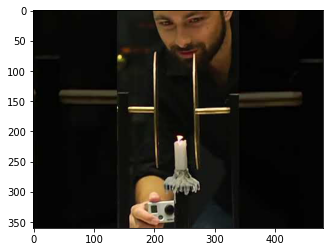

In [22]:
def get_img_from_url(url):
    """ Make a request for an url containing an image and returns an np array 
    containin the image.

    Returns an np array containing an image.
    """
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)

    return img

# Test
url = df_videos_api['thumbnail_url'][0]

img = get_img_from_url(url)
plt.imshow(img)

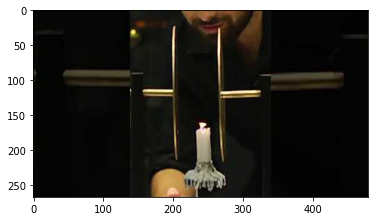

In [23]:
def remove_black_bars(img):
    """ Remove black bars from the top and from the bottom of the image.

    Returns an np array containing an image.
    """
    h, w, c = img.shape
    img = img[int(0.13*h):int(-0.13*h), :, :]

    return img

img = remove_black_bars(img)
plt.imshow(img)

In [24]:
def get_main_color_rgb(img):
    """ Get the RGB values of the most frequent color of an image.

    Returns a pandas series containing the red, green and blue values.

    """
    # Get width and height of Image
    width, height, channels = img.shape
 
    # Initialize Variable
    r_total = 0
    g_total = 0
    b_total = 0
 
    count = 0
 
    # Iterate through each pixel
    for x in range(0, width):
        for y in range(0, height):
            # r,g,b value of pixel
            r, g, b = img[x,y]
 
            r_total += r
            g_total += g
            b_total += b
            count += 1
 
    return pd.Series([int(r_total/count), int(g_total/count), int(b_total/count)])
    
r,g,b = get_main_color_rgb(img)
print(f"r: {r}, g: {g}, b:{b}")

r: 22, g: 19, b:14


In [25]:
df_videos_api[['thumb_red', 'thumb_green', 'thumb_blue']] = df_videos_api['thumbnail_url'].apply(lambda x: get_main_color_rgb(remove_black_bars(get_img_from_url(x))))

In [26]:
df_videos_api[['video_title','thumbnail_url','thumb_red','thumb_green','thumb_blue']].head()

,video_title,thumbnail_url,thumb_red,thumb_green,thumb_blue
0,Fire conducts electricity #shorts,https://i.ytimg.com/vi/QiVgJPVKRGI/hqdefault.jpg,22,19,14
1,The world depends on a strange collection of i...,https://i.ytimg.com/vi/esQyYGezS7c/hqdefault.jpg,125,113,110
2,But what is a convolution?,https://i.ytimg.com/vi/KuXjwB4LzSA/hqdefault.jpg,35,30,29
3,POSSO COLOCAR MINHA LINGUA NA SUA BOCA? : MAND...,https://i.ytimg.com/vi/55VfDUU1pyg/hqdefault.jpg,104,96,100
4,🐍 GRIXIS CROBA! O novo MID-RANGE do STANDARD! ...,https://i.ytimg.com/vi/bo53RcrZmc4/hqdefault.jpg,57,96,96


## 2.6) Get the number of words in the thumbnail (TO DO)

## 2.7) Get the number of human faces in the thumbnail (TO DO)

# **3) LOAD**

## 3.1) General methods to connect to DB

In [27]:
def connect_to_db(host_name, database, port, username, password):
    """ Connects to a database and returns the connection.
    host_name = typically an IP from AWS
    dbname = the type of the db (in my case, Postgres)
    port = the port that gives access to the db
    username = username of the db
    password = password of the db

    Returns a connection to a database.
    """
    try:
        conn = ps.connect(host=host_name, database=database, user=username, password=password, port=port)
    except ps.OperationalError as e:
        raise e
    else:
        print("Connected!")
    return conn

In [28]:
# create table
def create_table(curs, command):
    """ Creates a database table.
    curs = cursor for the postgres table
    """
    curs.execute(command)
    print("Table created!")       

## 3.2) Methods for "videos" table

In [42]:
def update_videos_row(curr, video_id, channel_id, video_title, thumbnail_url,
                    upload_date_time, video_duration, view_count, like_count, 
                    comment_count, n_words_title, n_question_marks_title,
                    n_exclamation_marks_title, n_ellipsis_title,
                    thumb_red, thumb_green, thumb_blue):
    """ Update a specific video_id entry of the db table
    """

    
    query = (
        """UPDATE videos
        SET video_title = %s,
            channel_id = %s,
            thumbnail_url = %s,
            upload_date_time = %s,
            video_duration = %s,
            view_count = %s,
            like_count = %s,
            comment_count = %s,
            n_words_title = %s,
            n_question_marks_title = %s,
            n_exclamation_marks_title = %s,
            n_ellipsis_title = %s,
            thumb_red = %s,
            thumb_green = %s,
            thumb_blue = %s
        WHERE video_id = %s;""")

    vars_to_update = (video_title, channel_id, thumbnail_url, \
                      upload_date_time, video_duration, view_count, \
                      like_count, comment_count,\
                      n_words_title, n_question_marks_title,\
                      n_exclamation_marks_title, n_ellipsis_title,\
                    thumb_red, thumb_green, thumb_blue, video_id)
    curr.execute(query, vars_to_update)

In [43]:
def update_videos_db(curr, df):
    """ Update the videos table for all video_id, or if the entry doesn't exist
    append it to a pandas df that will be returned.

    Returns a pandas df with new videos.
    """

    tmp_df = pd.DataFrame(columns=["video_id","channel_id","video_title",\
            "channel_title","thumbnail_url","upload_date_time",\
            "video_duration", "view_count","like_count","comment_count", \
            "n_words_title", "n_question_marks_title", \
            "n_exclamation_marks_title", "n_ellipsis_title", \
            "thumb_red","thumb_green", "thumb_blue"])

    for i, row in df.iterrows():
        if check_if_video_exists(curr, row['video_id']):
            update_videos_row(curr, row['video_id'], row['channel_id'], \
                                row['video_title'], row['thumbnail_url'], row['upload_date_time'], \
                                row['video_duration'], row['view_count'], row['like_count'], \
                                row['comment_count'], row['n_words_title'], row['n_question_marks_title'], \
                                row['n_exclamation_marks_title'], row['n_ellipsis_title'], row['thumb_red'], \
                                row['thumb_green'], row['thumb_blue'])
        else:
            tmp_df = tmp_df.append(row)

    return tmp_df

In [44]:
def check_if_video_exists(curr, video_id):
    """ Check if a given video_id exists in the database.

    """
    query = ("""SELECT video_id FROM videos WHERE video_id = %s""")
    curr.execute(query, (video_id,))

    return curr.fetchone() is not None

In [45]:
def insert_into_videos_table(curr, video_id, channel_id, video_title, \
                            thumbnail_url, upload_date_time, video_duration, \
                            view_count, like_count, comment_count,\
                            n_words_title, n_question_marks_title, \
                            n_exclamation_marks_title, n_ellipsis_title, \
                            thumb_red, thumb_green, thumb_blue):
    
    """ Insert a new video entry into the database.

    """

    insert_into_videos = (
        """INSERT INTO videos (video_id, channel_id, video_title, thumbnail_url, 
                upload_date_time, video_duration, view_count, like_count, 
                comment_count, n_words_title, n_question_marks_title,
                n_exclamation_marks_title, n_ellipsis_title,
                thumb_red, thumb_green, thumb_blue)
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);""")

    row_to_insert = (video_id, channel_id, video_title, thumbnail_url, \
                    upload_date_time, video_duration, view_count, like_count, \
                    comment_count, n_words_title, n_question_marks_title, \
                    n_exclamation_marks_title, n_ellipsis_title, \
                    thumb_red, thumb_green, thumb_blue)

    curr.execute(insert_into_videos, row_to_insert)

In [46]:
def append_from_videos_df_to_db(curr, df):
    """ Insert a list of videos from a pandas df in the database.

    """

    for i, row in df.iterrows():
        insert_into_videos_table(curr, row['video_id'], row['channel_id'], \
                                row['video_title'], row['thumbnail_url'], \
                                row['upload_date_time'], row['video_duration'],\
                                row['view_count'], row['like_count'],\
                                row['comment_count'], row['n_words_title'], \
                                row['n_question_marks_title'], row['n_exclamation_marks_title'], \
                                row['n_ellipsis_title'], row['thumb_red'], \
                                row['thumb_green'], row['thumb_blue'])

## 3.3) Methods for "channels" table

In [47]:
def update_channels_row(curr, channel_id, channel_title, channel_country, 
               total_view_count, subscriber_count, video_count, topic_categories):
    """ Update a specific channel_id entry of the db table.
    """
    query = (
        """UPDATE channels
        SET channel_title = %s,
            channel_country = %s,
            total_view_count = %s,
            subscriber_count = %s,
            video_count = %s,
            topic_categories = %s
        WHERE channel_id = %s;""")

    vars_to_update = (channel_title, channel_country, total_view_count, subscriber_count, video_count, topic_categories, channel_id)
    curr.execute(query, vars_to_update)

In [48]:
def update_channels_db(curr, df):
    """ Update the channels table for all channel_id, or if the entry doesn't exist,
    append it to a pandas df that will be returned.

    Returns a pandas df with new channels.
    """

    tmp_df = pd.DataFrame(columns=["channel_id","channel_title","channel_country","total_view_count","subscriber_count","video_count","topic_categories"])

    for i, row in df.iterrows():
        if check_if_channel_exists(curr, row['channel_id']):
            update_channels_row(curr, row['channel_id'], row['channel_title'], row['channel_country'], row['total_view_count'], row['subscriber_count'], row['video_count'], row['topic_categories'])
        else:
            tmp_df = tmp_df.append(row)

    return tmp_df

In [49]:
def check_if_channel_exists(curr, channel_id):
    """ Check if a given channel_id exists in the database.

    """
    query = ("""SELECT channel_id FROM channels WHERE channel_id = %s""")
    curr.execute(query, (channel_id,))

    return curr.fetchone() is not None

In [50]:
def insert_into_channels_table(curr, channel_id, channel_title, channel_country, view_count, subscriber_count, video_count, topic_categories):
    """ Insert a new channel entry in the database.

    """

    insert_into_channels = (
        """INSERT INTO channels (channel_id, channel_title, channel_country, total_view_count, subscriber_count, video_count, topic_categories)
            VALUES(%s, %s, %s, %s, %s, %s, %s);""")

    row_to_insert = (channel_id, channel_title, channel_country, view_count, subscriber_count, video_count, topic_categories)

    curr.execute(insert_into_channels, row_to_insert)

In [51]:
def append_from_channels_df_to_db(curr, df):
    """ Insert a list of channels from a pandas df in the database.

    """

    for i, row in df.iterrows():
        insert_into_channels_table(curr, row['channel_id'], row['channel_title'], row['channel_country'], row['total_view_count'], row['subscriber_count'], row['video_count'], row['topic_categories'])

## 3.4) Methods to add or remove a column from a table.

In [35]:
def add_column_to_table(curs, table_name, column_name, column_type, default=""):
    """ Add column to a table if it doesn't exist.
    curs = cursor for the postgres table
    table_name = the name of the table
    column_name = name of column
    column_type = type of column
    default = default value that the column will take
    """

    if default!="":
        default=f"DEFAULT {default}"

    add_column_command = (
        f""" ALTER TABLE IF EXISTS {table_name} 
            ADD IF NOT EXISTS {column_name} {column_type} {default}
        """
    )

    curs.execute(add_column_command)
    print("Column added!")


In [36]:
def remove_column_from_table(curs, table_name, column_name):
    """ Remove a column from a table if it exists.
    curs = cursor for the postgres table
    table_name = the name of the table
    column_name = name of column
    """

    remove_column_command = (
        f""" ALTER TABLE IF EXISTS {table_name} 
            DROP COLUMN IF EXISTS {column_name}
        """
    )

    curs.execute(remove_column_command)
    print("Column removed!")

## 3.5) Connect to AWS RDS and load the data.

In [55]:
host_name = "datascience-youtube.cuxnfdexw55l.us-east-1.rds.amazonaws.com"
database = "postgres"
port = "5432"
db_username = os.getenv("db_username")
db_password = os.getenv("db_password")
conn = None

conn = connect_to_db(host_name, database, port, db_username, db_password)

Connected!


In [56]:
curs = conn.cursor() # allows us to run SQL commands and fetch results

In [57]:
videos_create_command = (
        """CREATE TABLE IF NOT EXISTS videos (
            video_id VARCHAR(255) PRIMARY KEY,
            channel_id VARCHAR(255) NOT NULL,
            video_title TEXT NOT NULL,
            thumbnail_url TEXT NOT NULL,
            upload_date_time TIMESTAMPTZ NOT NULL DEFAULT CURRENT_TIMESTAMP,
            video_duration INTEGER NOT NULL,
            view_count INTEGER NOT NULL,
            like_count INTEGER NOT NULL,
            comment_count INTEGER NOT NULL,
            n_words_title INTEGER NOT NULL,
            n_question_marks_title INTEGER NOT NULL,
            n_exclamation_marks_title INTEGER NOT NULL,
            n_ellipsis_title INTEGER NOT NULL,
            thumb_red INTEGER NOT NULL,
            thumb_green INTEGER NOT NULL,
            thumb_blue INTEGER NOT NULL
        )""")

create_table(curs, videos_create_command)

Table created!


In [58]:
channels_create_command = (
    """CREATE TABLE IF NOT EXISTS channels (
            channel_id VARCHAR(255) PRIMARY KEY,
            channel_title VARCHAR(255) NOT NULL,
            channel_country VARCHAR(255) NOT NULL,
            total_view_count INTEGER NOT NULL,
            subscriber_count INTEGER NOT NULL,
            video_count INTEGER NOT NULL,
            topic_categorieS TEXT
        )""")

create_table(curs, channels_create_command)

Table created!


In [ ]:
# add_column_to_table(curs,"videos", "upload_hour", "VARCHAR(10) NOT NULL",0)
# remove_column_from_table(curs,"videos","upload_hour")
# add_column_to_table(curs,"channels","total_view_count","INTEGER NOT NULL","0")
# remove_column_from_table(curs,"videos","video_duration")

In [59]:
new_videos_df = update_videos_db(curs, df_videos_api)

In [60]:
new_channels_df = update_channels_db(curs, df_channels_api)

In [61]:
append_from_videos_df_to_db(curs, new_videos_df)

In [62]:
append_from_channels_df_to_db(curs, new_channels_df)

In [63]:
conn.commit()

#**Conclusion**

We have succesfuly used the Youtube API, extracted the data that we wanted (and we can always revisit this if we want to analyze other things or create more complex prediction models), transformed it (by applying regular expressions, changing some units and checking the main color of the thumbnail) and finished it up by loading the data in an AWS RDS running Postgres. 

In the next section we will analyze all this data!

Let's go:  https://colab.research.google.com/drive/1a_Etj5kwEaq5epwoV9TVPNS3ShRRd7wU?usp=sharing